## Part 2: Clinical Application

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

### Code

In [2]:
# !pip install -U seaborn

In [3]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [4]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [5]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [6]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = filename.split("/")[-1].split(".")[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata['subject']==subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata['subject']==subject]['sex'].values[0]

    return age_group, sex, rhr

In [7]:
df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

df.head()

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


#### Plot Resting Heart Rate vs. Age Group

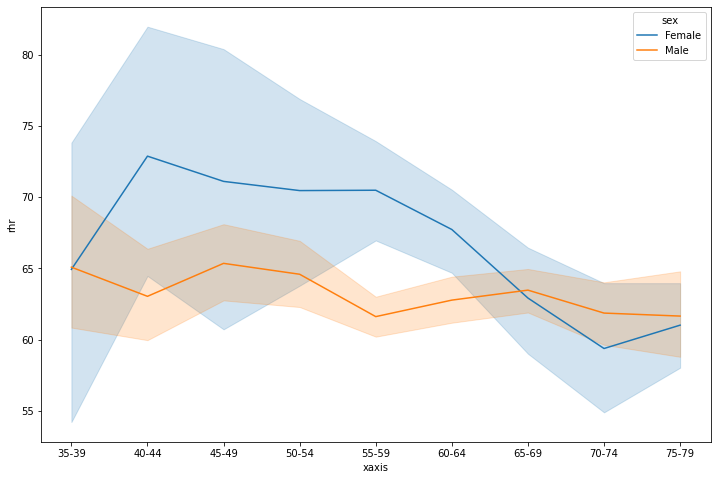

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df, ci = 95)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion

- For woman, we see that the RHR exhibits strong correlation with age (i.e., increases up until middle age and then gradually decreases) which is the expected trend.

- For men, we see that RHR exhibits weaker correlation with age, although shows a decreasing trend thoughout the entire age range which is not the expected trend.

- The average female RHR is generally higher than that of male up until late 60s. Female RHR fluctuates considerably (as represented by a wider 95% CI) comparing to that of male and shows a large variation particularly for the age range of 35-54 years.

- The larger variation in female RHR could be due to a smaller sample size and unbalanced dataset (i.e., more men in the sample than women). Another possible reason could be that the variation in health condition of the women was much larger than that of men in the sample. On the  other hand, the lack of expected trend in male RHR might be due to a high level of fitness of the users/participants with respect to the general population. This difference in RHR between men and women is largely accounted for by the size of the heart, which is typically smaller in females than males. The smaller female heart, pumping less blood with each beat, needs to beat at a faster rate to match the larger male heart’s output.

- To figure out what is really happening, we need to investigate more informative clinical metadata (such as body mass index, fitness level and any medical condition). We also need to check if the trial participants use any medications (such as betablcoker) that can affect the RHR. The air temerature and humidity can also affect the RHR so it is also important to record these data at the time of measuring the RHR. Therefore in order to improve the accuracy of the results, we need to enlarge the dataset to incorporate a wider variation of fitness levels and other metadata for both men and women and conduct additional EDA to determine the ratio of male and female participants for all age group.

- We validated the trend that average RHR increases up until middle age and then decreases into old age for women. However, we could not validate this trend for men. We only see that the male RHR exhibits a decreasing trend over time from age 35 to age 79.